# Bootstrap

In [39]:
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18

---
## Example 1. You record the time interval between spikes for a neuron, and would like to estimate the spike rate of the neuron from your recordings.

### Assume the actual average spike rate of the neuron is 5 spikes/sec, and simulate what your measured data might look like.

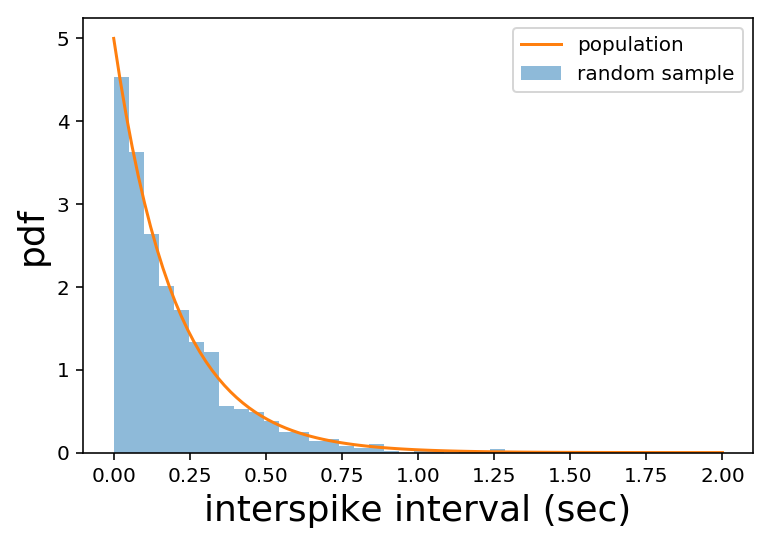

In [40]:
spikeRatePerSec = 5
interspikeIntervalDist = st.expon(loc=0, scale=1/spikeRatePerSec)

simultedInterspikeIntervals = interspikeIntervalDist.rvs(size=(1000,))

plt.hist(simultedInterspikeIntervals, bins=30, density=True, alpha=0.5, label='random sample')
intervals_sec = np.linspace(0, 2, 100)
plt.plot(intervals_sec, interspikeIntervalDist.pdf(intervals_sec), label='population')
plt.xlabel('interspike interval (sec)')
plt.ylabel('pdf')
plt.legend();

### What is your best estimate of the neurons spike rate based on your simulated data?

In [42]:
loc, scale = st.expon.fit(simultedInterspikeIntervals, floc=0)
mleSpikeRatePerSec = 1 / scale
print(f"Maximum likelihood estimate of spike rate is {mleSpikeRatePerSec :.3f} per second.")

Maximum likelihood estimate of spike rate is 5.147 per second.


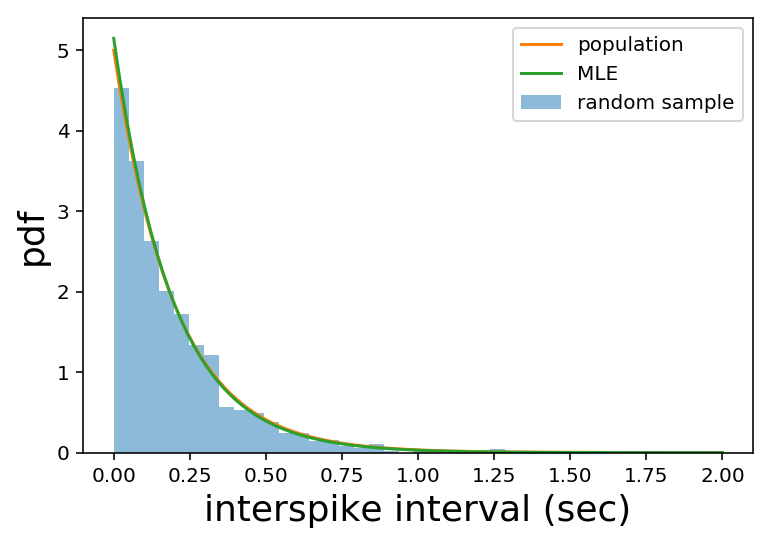

In [44]:
mleInterspikeIntervalDist = st.expon(loc=0, scale=1/mleSpikeRatePerSec)

plt.hist(simultedInterspikeIntervals, bins=30, density=True, alpha=0.5, label='random sample')
intervals_sec = np.linspace(0, 2, 100)
plt.plot(intervals_sec, interspikeIntervalDist.pdf(intervals_sec), label='population')
plt.plot(intervals_sec, mleInterspikeIntervalDist.pdf(intervals_sec), label='MLE')
plt.xlabel('interspike interval (sec)')
plt.ylabel('pdf')
plt.legend();

### How confident are you in your estimated spike rate?

### Construct a 95% bootstrap confidence interval (i.e. an interval of spike rates that you are 95% sure contains the neuron's true average spike rate).

### But first, an example of random choice with replacement.

In [6]:
x = list(range(11))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [7]:
# Five random selections of the same size as x with replacement.
for i in range(5):
    x2 = np.random.choice(x, size=len(x), replace=True)
    print(x2)

[6 9 3 4 4 8 1 3 5 9 2]
[9 4 5 3 7 6 9 7 3 2 5]
[ 5 10  3  1  3  6  6  8  2  9  6]
[ 9  2  1  8  3 10  9  1  0  2  9]
[ 6 10  5 10  8  6  2  4  7 10  8]


### Ok, now construct a 95% bootstrap confidence interval (i.e. an interval of spike rates that you are 95% sure contains the neuron's true average spike rate).

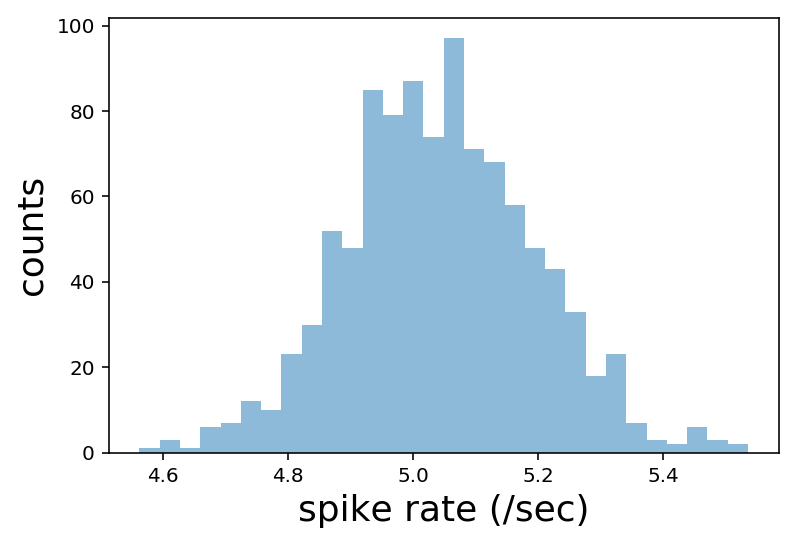

In [10]:
numObservations = len(simultedInterspikeIntervals)
numBootstrapSampleSets = 1000

# create memory for estimated spike rate from each bootstrap sample set
bootstrapSpikeRates = np.zeros((numBootstrapSampleSets,))

# Create each bootstrap sample set from the original observations
# and compute its estimated spike rate
for i in range(numBootstrapSampleSets):
    bootstrapInterspikeIntervals = np.random.choice(simultedInterspikeIntervals, 
                                                    size=simultedInterspikeIntervals.shape, replace=True)
    loc, scale = st.expon.fit(bootstrapInterspikeIntervals, floc=0)
    bootstrapSpikeRates[i] = 1 / scale

# plot histogram of bootstrapped spike rates
plt.hist(bootstrapSpikeRates, 30, alpha=0.5)
plt.xlabel('spike rate (/sec)')
plt.ylabel('counts');

### Find the 2.5% and 97.5% quantiles from your bootstrapped spike rates.

### These will be the 95% confidence limits.

MLE of spike rate is 5.033 /sec.
95% confidence interval of spike rate estimate within 4.745 to 5.335 /sec.


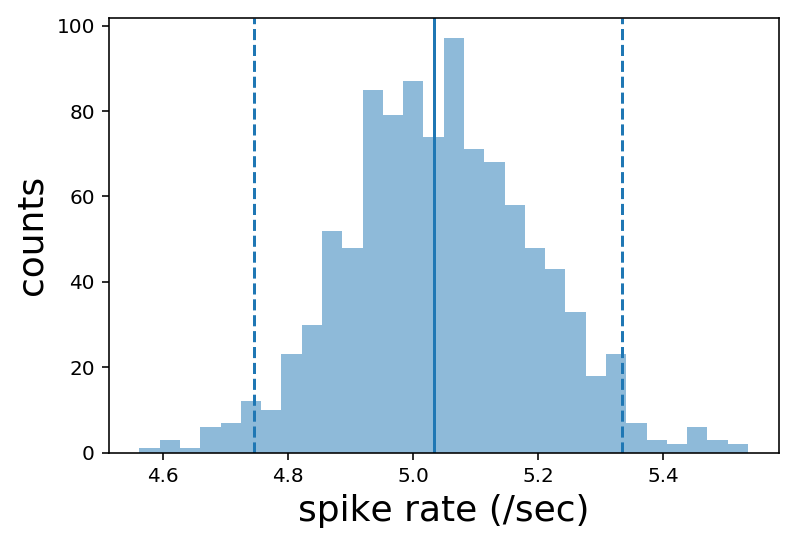

In [18]:
lb, ub = np.quantile(bootstrapSpikeRates, [0.025, 0.975])

print(f"MLE of spike rate is {mleSpikeRatePerSec :.3f} /sec.")
print(f"95% confidence interval of spike rate estimate within {lb :.3f} to {ub :.3f} /sec.")

# !!! Best estimate is MLE spike rate from actual observations,
#     NOT mean of bootstrapped distribution.
# !!! Bootstrapped distribution just gives confidence limits, 
#     which do NOT need to be symmetric about the MLE.
plt.hist(bootstrapSpikeRates, 30, alpha=0.5)
plt.axvline(mleSpikeRatePerSec)
plt.axvline(lb, linestyle='--')
plt.axvline(ub, linestyle='--')
plt.xlabel('spike rate (/sec)')
plt.ylabel('counts');

### Note that in above plot:

1. Best estimate is MLE of spike rate from **actual observations**, *NOT* mean of bootstrapped distribution.
2. Bootstrapped distribution just gives confidence limits, which do *NOT* need to be symmetric about the MLE.

---
## Example 2. You can apply bootstrap to ANY statistic you can calculate.

### You measure a protein's expression level for a series of cells, and would like to estimate both the distribution of expression levels in the entire cell population in this brain region and your confidence in your estimated distribution parameters.

### Assume that expression levels are normally distributed with an average expression level of 50 and standard deviation of 10 across cells. Simulate what your measured data set might look like and plot it with the assumed distribution shown for reference.

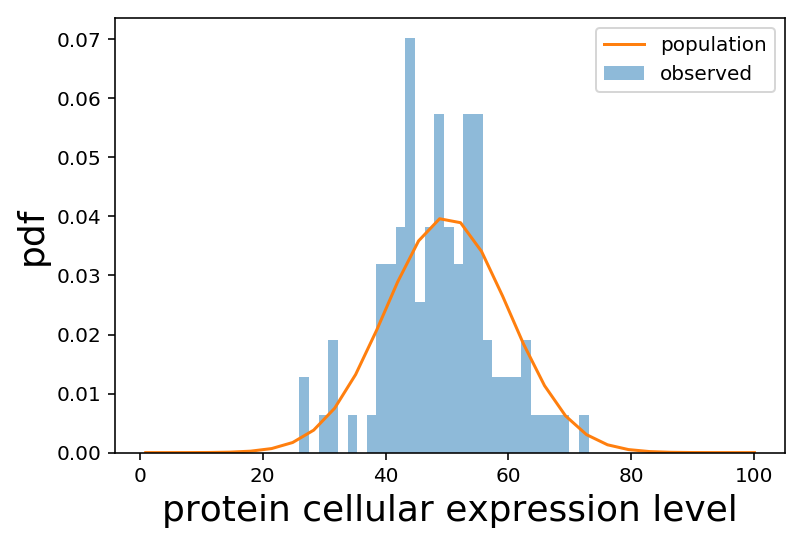

In [55]:
expressionLevelPopulationDist = st.norm(50, 10)

numObservations = 100
simulatedMeasuredExpressionLevels = expressionLevelPopulationDist.rvs(size=(numObservations,))

plt.hist(simulatedMeasuredExpressionLevels, 30, density=True, alpha=0.5, label='observed')
x = np.linspace(1, 100, 30)
plt.plot(x, expressionLevelPopulationDist.pdf(x), label='population')
plt.xlabel('protein cellular expression level')
plt.ylabel('pdf')
plt.legend();

### What is your best estimate for the mean and variance in expression level in the simulated sample?

In [56]:
mu, sd = st.norm.fit(simulatedMeasuredExpressionLevels)
print(f"MLE of mean expression level in sample is {mu :.1f} per cell.")
print(f"MLE of standard deviation in expression levels in sample is {sd :.1f}")

MLE of mean expression level in sample is 48.8 per cell.
MLE of standard deviation in expression levels in sample is 8.8


### Using Central Limit Theorem, what is your best estimate for the 95% confidence interval in our estimate of the population's mean expression level?

In [57]:
sem = sd / np.sqrt(numObservations)

print(f"Estimate of mean expression level in population is {mu :.1f} ± {sem :.1f} per cell.")

Estimate of mean expression level in population is 48.8 ± 0.9 per cell.


### Use bootstrap to estimate the confidence interval on both your estimate of the mean and standard deviation.

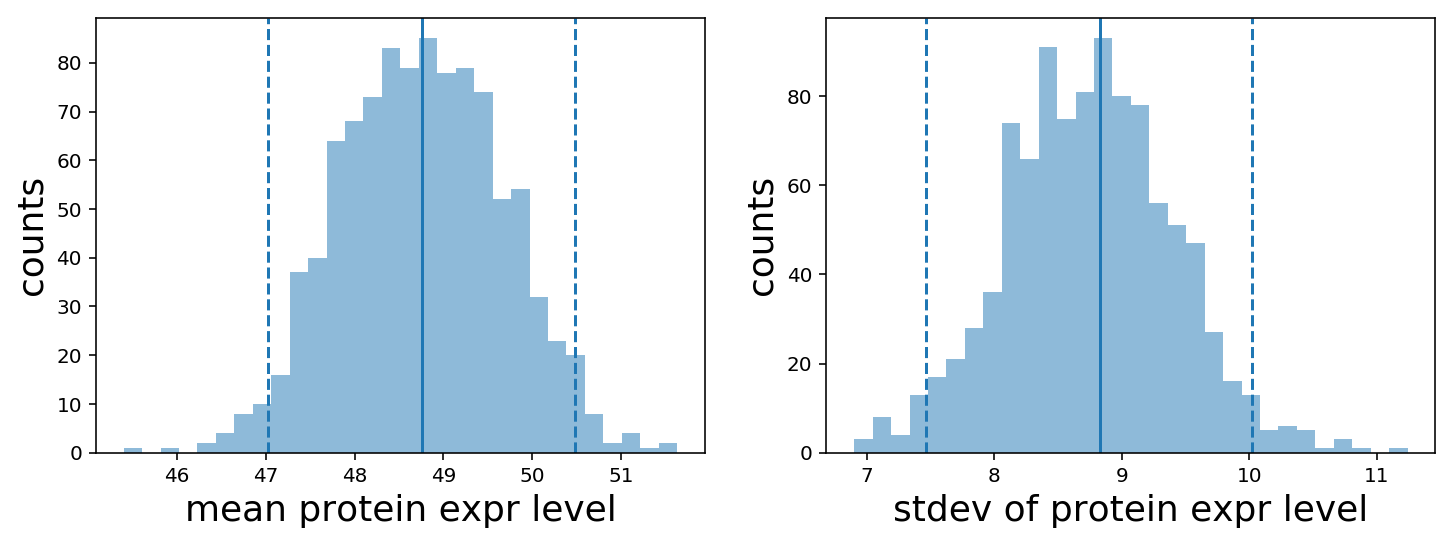

In [58]:
numBootstrapSampleSets = 1000

bootstrapMeans = np.zeros((numBootstrapSampleSets,))
bootstrapStdevs = np.zeros((numBootstrapSampleSets,))

for i in range(numBootstrapSampleSets):
    bootstrapObservations = np.random.choice(simulatedMeasuredExpressionLevels, 
                                             size=simulatedMeasuredExpressionLevels.shape, replace=True)
    bmu, bsd = st.norm.fit(bootstrapObservations)
    bootstrapMeans[i] = bmu
    bootstrapStdevs[i] = bsd

bootstrapMeanCI = np.quantile(bootstrapMeans, [0.025, 0.975])
bootstrapStdevCI = np.quantile(bootstrapStdevs, [0.025, 0.975])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(bootstrapMeans, bins=30, alpha=0.5)
plt.axvline(mu)
plt.axvline(bootstrapMeanCI[0], linestyle='--')
plt.axvline(bootstrapMeanCI[1], linestyle='--')
plt.xlabel('mean protein expr level')
plt.ylabel('counts');

plt.subplot(1, 2, 2)
plt.hist(bootstrapStdevs, bins=30, alpha=0.5)
plt.axvline(sd)
plt.axvline(bootstrapStdevCI[0], linestyle='--')
plt.axvline(bootstrapStdevCI[1], linestyle='--')
plt.xlabel('stdev of protein expr level')
plt.ylabel('counts');

### Compare your estimate to the known values of the distribution you used to simulate the data.

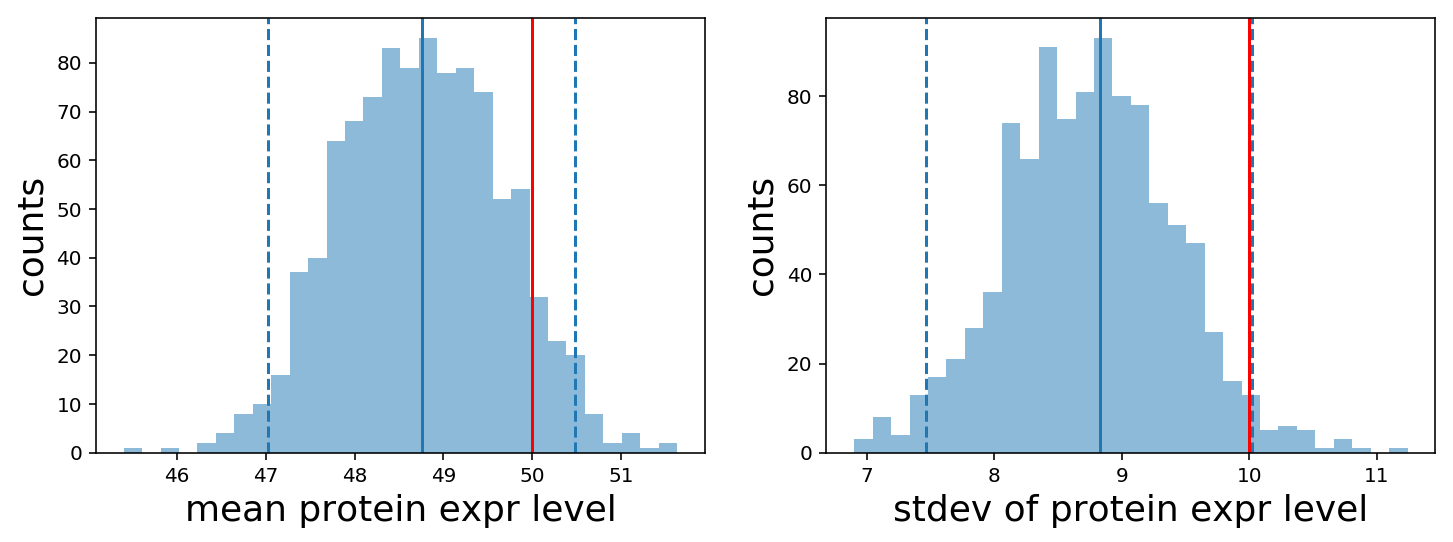

In [59]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(bootstrapMeans, bins=30, alpha=0.5)
plt.axvline(mu)
plt.axvline(bootstrapMeanCI[0], linestyle='--')
plt.axvline(bootstrapMeanCI[1], linestyle='--')
plt.axvline(50, color='r')
plt.xlabel('mean protein expr level')
plt.ylabel('counts');

plt.subplot(1, 2, 2)
plt.hist(bootstrapStdevs, bins=30, alpha=0.5)
plt.axvline(sd)
plt.axvline(bootstrapStdevCI[0], linestyle='--')
plt.axvline(bootstrapStdevCI[1], linestyle='--')
plt.axvline(10, color='r')
plt.xlabel('stdev of protein expr level')
plt.ylabel('counts');

### Notice that we are a bit off from the true values of the population distribution from which the 100 random samples came.

### <font color=red>Exercise:</font>

1. If you measured a mean expression level of 55.2 under new test conditions, would you conclude that the test conditions had an effect on mean expression level?
2. If under the same new test conditions you measure a standard deviation in expression levels of 8.3, would you conclude that the new conditions affected the variability of expression?
3. What if we took 1000 samples instead of 100? How much better would our estimates be? Try it.